In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

TEST_SIZE = 0.4
RANDOM_STATE = 42

In [13]:
from sklift.datasets import fetch_criteo

data, outcome, treatment = fetch_criteo(
    target_col="conversion",
    treatment_col="exposure",
    return_X_y_t=True,
    data_home="../data/",
    download_if_missing=True,
)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, t_train, t_test, y_train, y_test = train_test_split(
    data,
    treatment,
    outcome,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
)
X_train.shape, X_test.shape, t_train.shape, t_test.shape, y_train.shape, y_test.shape

((8387755, 12), (5591837, 12), (8387755,), (5591837,), (8387755,), (5591837,))

In [20]:
y_train.value_counts(normalize=True)

conversion
0    0.997091
1    0.002909
Name: proportion, dtype: Float64

In [19]:
y_test.value_counts(normalize=True)

conversion
0    0.997072
1    0.002928
Name: proportion, dtype: Float64

In [21]:
t_train.value_counts(normalize=True)

exposure
0    0.969329
1    0.030671
Name: proportion, dtype: Float64

In [22]:
t_test.value_counts(normalize=True)

exposure
0    0.969428
1    0.030572
Name: proportion, dtype: Float64

## S-learner

In [15]:
from causalml.inference.meta import BaseSClassifier
from lightgbm import LGBMClassifier

model_s = BaseSClassifier(learner=LGBMClassifier())
model_s.fit(X_train, t_train, y_train)

[LightGBM] [Info] Number of positive: 24400, number of negative: 8363355
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.168646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1707
[LightGBM] [Info] Number of data points in the train set: 8387755, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002909 -> initscore=-5.837032
[LightGBM] [Info] Start training from score -5.837032


In [16]:
tau_test = model_s.predict(X_test)
tau_test.shape

(5591837, 1)

In [23]:
eval_df = pd.DataFrame({"tau": tau_test.reshape(-1), "t": t_test, "y": y_test})

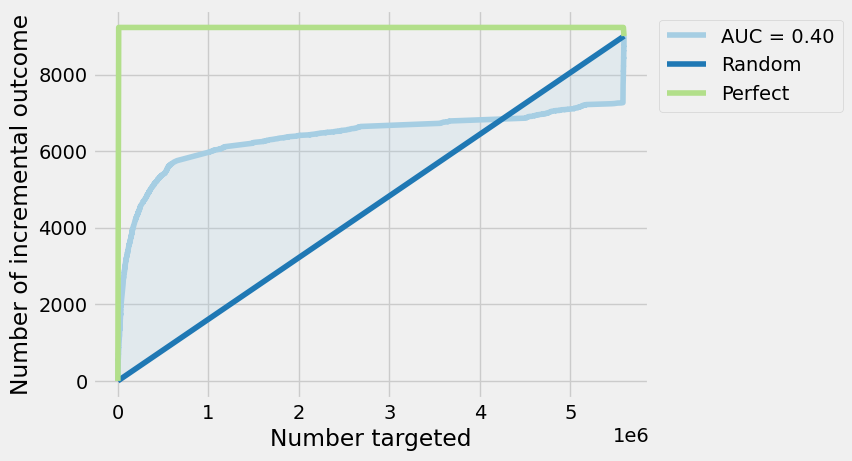

In [24]:
from src.viz import plot_qini_curve

plot_qini_curve(
    eval_df["y"],
    eval_df["tau"],
    eval_df["t"],
)

<Axes: title={'center': 'Uplift Bins'}, xlabel='Bin', ylabel='Actual Uplift Mean'>

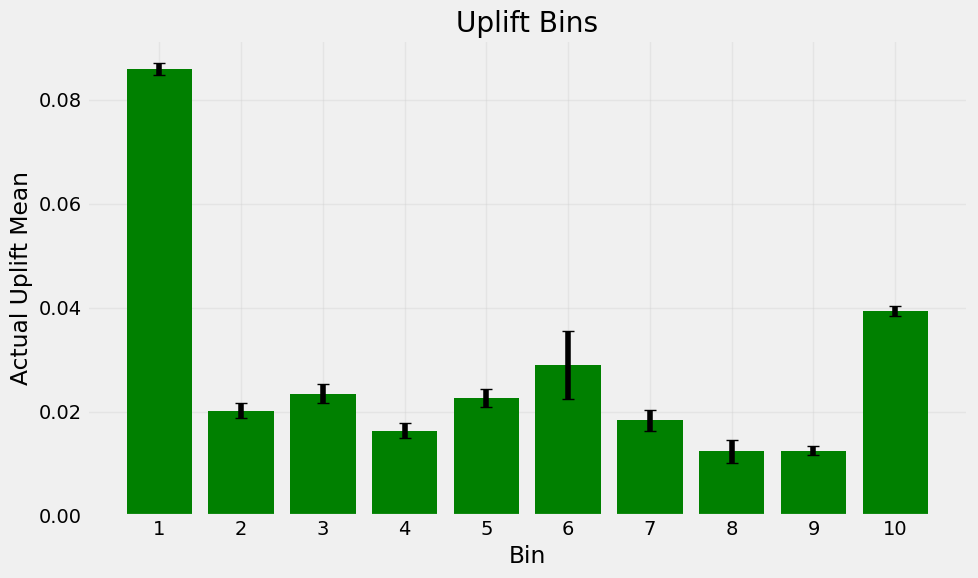

In [25]:
from src.viz import plot_uplift_bins

plot_uplift_bins(
    eval_df["t"],
    eval_df["y"],
    eval_df["tau"],
)

## T-learner

In [26]:
from causalml.inference.meta import BaseTClassifier

model_t = BaseTClassifier(learner=LGBMClassifier())
model_t.fit(X_train, t_train, y_train)

[LightGBM] [Info] Number of positive: 10601, number of negative: 8119895
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.193128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1672
[LightGBM] [Info] Number of data points in the train set: 8130496, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001304 -> initscore=-6.641124
[LightGBM] [Info] Start training from score -6.641124
[LightGBM] [Info] Number of positive: 13799, number of negative: 243460
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2045
[LightGBM] [Info] Number of data points in the train set: 257259, number of used features: 12
[LightGBM] [

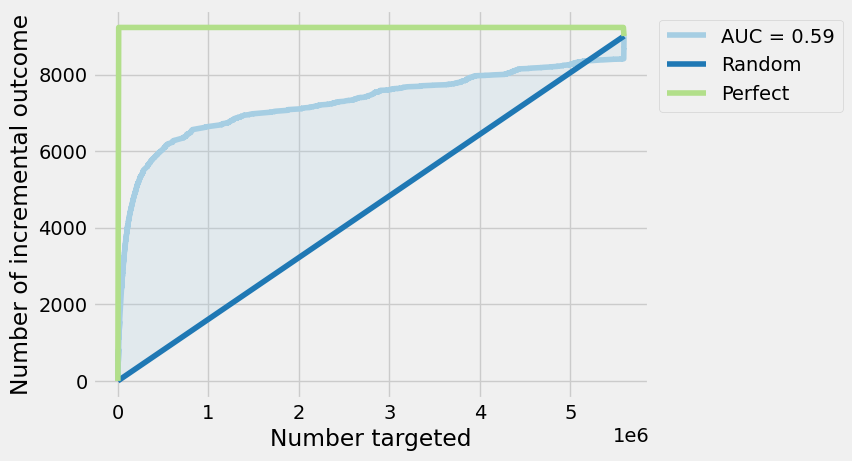

In [27]:
plot_qini_curve(
    y_test,
    model_t.predict(X_test).reshape(-1),
    t_test,
)

<Axes: title={'center': 'Uplift Bins'}, xlabel='Bin', ylabel='Actual Uplift Mean'>

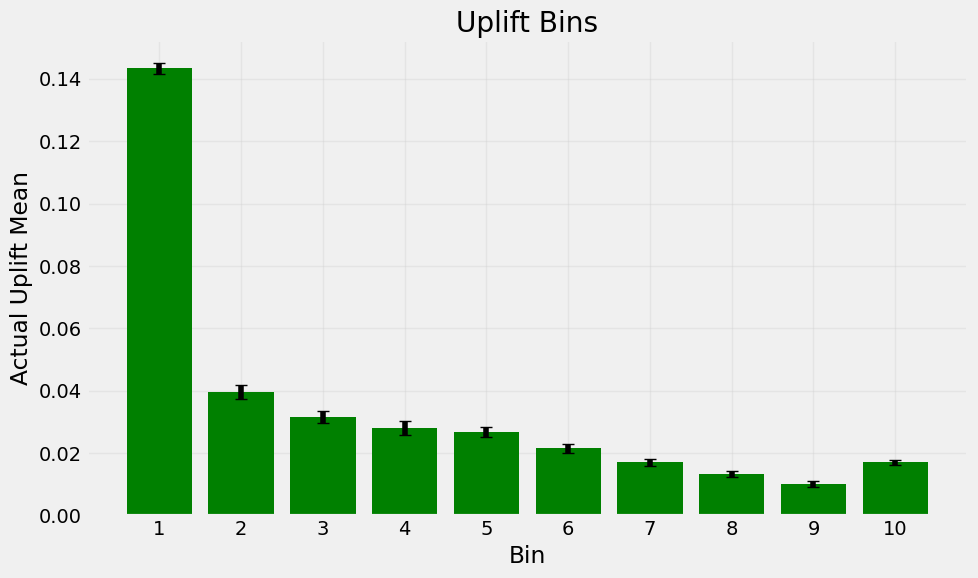

In [28]:
plot_uplift_bins(
    t_test,
    y_test,
    model_t.predict(X_test).reshape(-1),
)